# Analysis of MS Fredrika

### Preamble
Imports and constants

In [21]:
from py_fish.operation import (
    speed_profile_from_data,
    total_consumption_from_profile,
    consumption_profile_from_data,
    extract_transit_speed,
)
from py_fish.plotting import (
    plot_speed_profile,
    plot_consumption_data,
    plot_profiles,
    plot_power_data,
)
from py_fish.engine import (
    calculate_consumption,
    EngineApplication,
    calculate_power_from_consumption,
)
from py_fish.loads import (
    calculate_propulsion_power,
    calculate_dc_energy,
    calculate_hydraulics_energy,
)
from py_fish.data import load_all_days, extract_low_acceleration
from py_fish.stats import predband


from py_fish.utils import components_to_profile
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d
from pathlib import Path
import os

In [22]:
ENGINE_RATING = 242.0
LENGTH = 11.91
BEAM = 4
DATE = "2023-10-24"

Dates 2023-10-24 and 2023-10-30 gives significantly less predicted consumption.
Both have significant acceleration time.

### Speed profile
Plot of speed profile for specified date

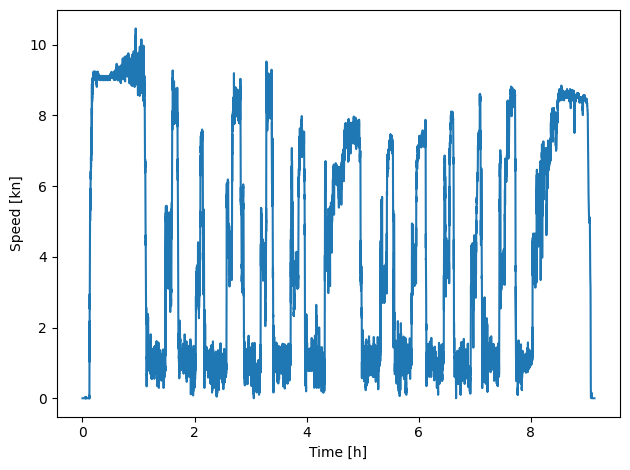

In [23]:
fig, ax = plt.subplots()
plot_speed_profile(speed_profile_from_data(DATE), ax=ax)
fig.tight_layout()

### All consumption data compared with Kemp model

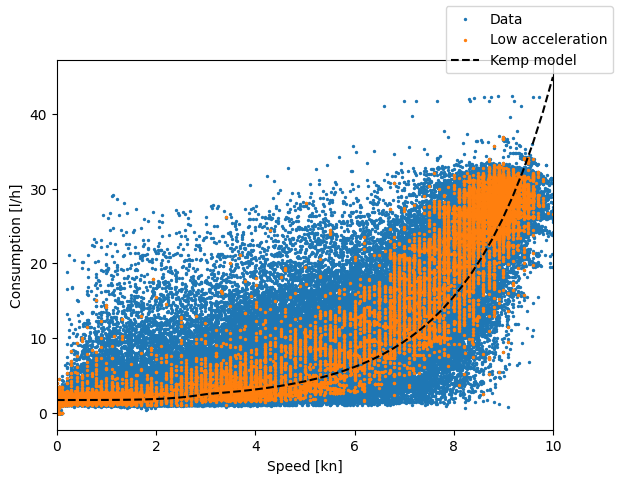

In [24]:
fig, ax = plt.subplots()
df = load_all_days()
speeds = np.linspace(0, 10)

speed_and_consumption = df.select(["speed", "consumption"]).to_numpy()
low_acceleration_speed_and_consumption = extract_low_acceleration(speed_and_consumption)

propulsion_powers_kemp = calculate_propulsion_power(
    speeds=speeds, length=LENGTH, beam=BEAM
)
propulsion_consumptions_kemp = calculate_consumption(
    powers=propulsion_powers_kemp,
    engine_rating=ENGINE_RATING,
    engine_application=EngineApplication.PROPULSION,
)

plot_consumption_data(speed_and_consumption, ax, label="Data")
plot_consumption_data(
    low_acceleration_speed_and_consumption, ax, label="Low acceleration"
)
ax.plot(
    speeds,
    propulsion_consumptions_kemp,
    label="Kemp model",
    color="black",
    linestyle="--",
)
fig.legend()

### Fit power models
Assumes engine consumption model by Kemp to be accurate, fits load model to the data

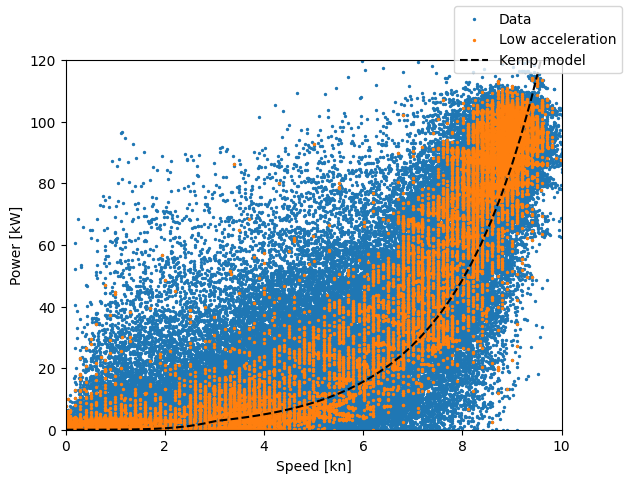

In [25]:
fig, ax = plt.subplots()
speed_and_power = components_to_profile(
    speed_and_consumption[:, 0],
    calculate_power_from_consumption(
        consumptions=speed_and_consumption[:, 1],
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION,
    ),
)
low_acceleration_speed_and_power = components_to_profile(
    low_acceleration_speed_and_consumption[:, 0],
    calculate_power_from_consumption(
        consumptions=low_acceleration_speed_and_consumption[:, 1],
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION,
    ),
)

plot_power_data(speed_and_power, ax, label="Data")
plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.plot(
    speeds, propulsion_powers_kemp, label="Kemp model", color="black", linestyle="--"
)
fig.legend()

Fits the constant parameter of the kemp model, i.e. not changeing the exponent

Power increawse with fit: 11.56%


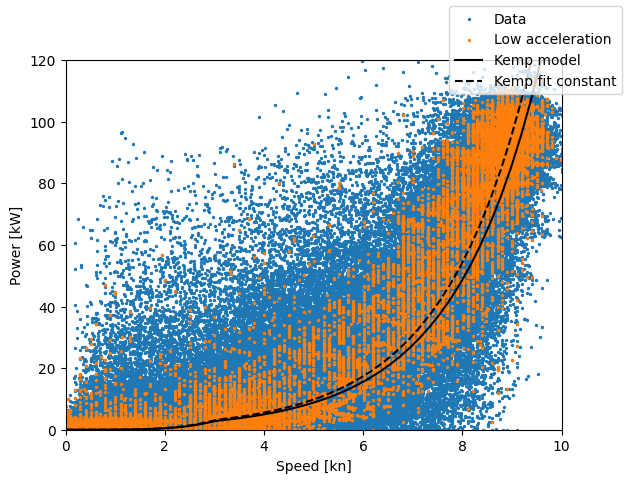

In [26]:
def power_function(speed: float, c4: float) -> float:
    return calculate_propulsion_power(
        speeds=np.ones((1, 1), dtype=float) * speed, length=LENGTH, beam=BEAM, c4=c4
    )[0]


popt, pcov = curve_fit(
    power_function,
    low_acceleration_speed_and_power[:, 0],
    low_acceleration_speed_and_power[:, 1],
)
fig, ax = plt.subplots()
plot_power_data(speed_and_power, ax, label="Data")
plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.plot(speeds, propulsion_powers_kemp, label="Kemp model", color="black")
ax.plot(
    speeds,
    calculate_propulsion_power(speeds=speeds, length=LENGTH, beam=BEAM, c4=popt[0]),
    label="Kemp fit constant",
    color="black",
    linestyle="--",
)
fig.legend()


power_increase = popt[0] / 3.6e-3
print(f"Power increawse with fit: {(power_increase-1)*100.0:.2f}%")

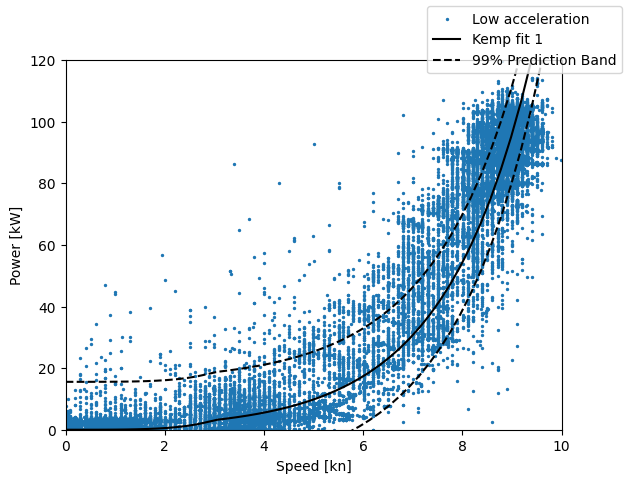

In [27]:
fig, ax = plt.subplots()
plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.plot(
    speeds,
    calculate_propulsion_power(speeds=speeds, length=LENGTH, beam=BEAM, c4=popt[0]),
    label="Kemp fit 1",
    color="black",
    linestyle="-",
)
lpb, upb = predband(
    speeds,
    low_acceleration_speed_and_power[:, 0],
    low_acceleration_speed_and_power[:, 1],
    popt,
    power_function,
    conf=0.99,
)
plt.plot(speeds, lpb, "k--", label="99% Prediction Band")
plt.plot(speeds, upb, "k--")
fig.legend()

### Extract transit
Extract operational modes for the selected date and calculate time fishing

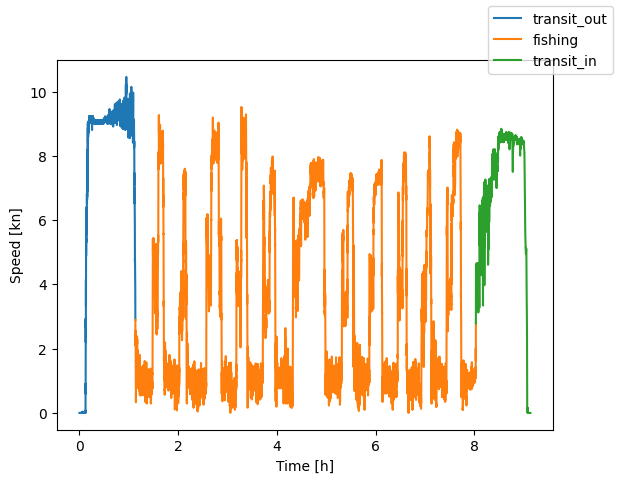

In [28]:
fig, ax = plt.subplots()
measured_speed_profile = speed_profile_from_data(DATE)
(transit_out, fishing, transit_in) = extract_transit_speed(measured_speed_profile)
time_fishing = fishing[-1, 0] - fishing[0, 0]
plot_profiles(ax, transit_out=transit_out, fishing=fishing, transit_in=transit_in)
ax.set_xlabel("Time [h]")
ax.set_ylabel("Speed [kn]")
fig.legend()

### Compare measured and approximated fuel usage for one day

92.75761958114056 84.6121079314574


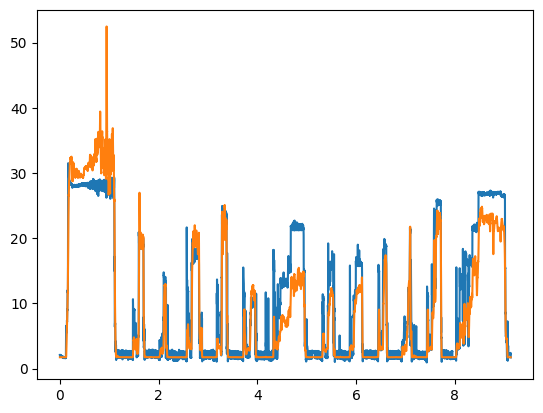

In [29]:
measured_consumption_profile = consumption_profile_from_data(DATE)
measured_consumption = total_consumption_from_profile(measured_consumption_profile)
model_power = (
    calculate_propulsion_power(
        speeds=uniform_filter1d(measured_speed_profile[:, 1], size=30),
        length=LENGTH,
        beam=BEAM,
    )
    * power_increase
)
model_consumption_profile = components_to_profile(
    measured_consumption_profile[:, 0],
    calculate_consumption(
        powers=model_power,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION,
    ),
)

model_consumption_propulsion = total_consumption_from_profile(model_consumption_profile)
power_hydraulics = calculate_hydraulics_energy(
    hours_fishing=time_fishing, hydraulic_deck_load_power=2.0
)
power_dc = calculate_dc_energy(
    hours_total=measured_speed_profile[-1, 0] - measured_speed_profile[0, 0]
)
hydraulics_consumption = calculate_consumption(
    powers=power_hydraulics,
    engine_rating=ENGINE_RATING,
    engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
)
dc_consumption = calculate_consumption(
    powers=power_dc,
    engine_rating=ENGINE_RATING,
    engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
)

fig, ax = plt.subplots()
plot_profiles(
    ax,
    measured_consumption=measured_consumption_profile,
    model_consumption=model_consumption_profile,
)
print(
    measured_consumption,
    model_consumption_propulsion + hydraulics_consumption + dc_consumption,
)

### Compare measured and approximated fuel usage for all days

In [30]:
data_dir = Path(os.path.abspath("")).resolve() / "py_fish" / "fredrika"
files = [f for f in data_dir.iterdir() if f.is_file()]
output = open("fredrika_consumptions.csv", "w")
output.write("date,measured,propulsion,hydraulics,dc,total,kwh\n")
output.close()
output = open("fredrika_consumptions.csv", "a")
for file in files:
    DATE = file.name[3:13]
    measured_speed_profile = speed_profile_from_data(DATE)
    (transit_out, fishing, transit_in) = extract_transit_speed(measured_speed_profile)
    time_fishing = fishing[-1, 0] - fishing[0, 0]
    measured_consumption_profile = consumption_profile_from_data(DATE)
    measured_consumption = total_consumption_from_profile(measured_consumption_profile)
    model_power = (
        calculate_propulsion_power(
            speeds=uniform_filter1d(measured_speed_profile[:, 1], size=30),
            length=LENGTH,
            beam=BEAM,
        )
        * power_increase
    )
    model_power_total = total_consumption_from_profile(
        components_to_profile(measured_consumption_profile[:, 0], model_power)
    )
    model_consumption_profile = components_to_profile(
        measured_consumption_profile[:, 0],
        calculate_consumption(
            powers=model_power,
            engine_rating=ENGINE_RATING,
            engine_application=EngineApplication.PROPULSION,
        ),
    )
    model_consumption_propulsion = total_consumption_from_profile(
        model_consumption_profile
    )
    power_hydraulics = calculate_hydraulics_energy(
        hours_fishing=time_fishing, hydraulic_deck_load_power=2.0
    )
    power_dc = calculate_dc_energy(
        hours_total=measured_speed_profile[-1, 0] - measured_speed_profile[0, 0]
    )
    hydraulics_consumption = calculate_consumption(
        powers=power_hydraulics,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
    )
    dc_consumption = calculate_consumption(
        powers=power_dc,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
    )
    output.write(
        f"{DATE},{measured_consumption},{model_consumption_propulsion},{hydraulics_consumption},{dc_consumption},{model_consumption_propulsion + hydraulics_consumption + dc_consumption},{model_power_total + power_dc + power_hydraulics}\n"
    )

output.close()